In [1]:
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from ipywidgets import interact
import matplotlib.patches as patches
from importlib import reload 
import DVA_RFI as rfi
import DVA_RFI_2 as rfi2

#### Change the directory to where the files are located" ####
day ='25'
directory = '../DVA/Data_Files/DVA_Day_Surveys/'

### Read in the file listing azimuth scan start and stop times:

In [2]:
scan_id = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)

# Read in the data and store it in arrays:
with open(directory+'DVAsurvey_phase1_day0'+day+'.txt') as fp:
    for line in fp:       
        scan_id.append(int(line.split()[0]))
        scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
        scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])
        
# Print out the scan numbers with their start and stop times:
for i in range(0,len(scan_id)):
    print(f"{scan_id[i]:04}",scan_start[i],scan_stop[i])

# Convert start and stop times to Modified Julian Day (MJD).
# This is needed for plotting and for selecting out data collected
# between particular times:
scan_start_mjd = Time(scan_start, format='isot',scale='utc').mjd
scan_stop_mjd  = Time(scan_stop,  format='isot',scale='utc').mjd


1052 2022-07-04T03:57:53.110 2022-07-04T04:15:55.184
2565 2022-07-04T04:20:37.406 2022-07-04T04:38:39.310
2566 2022-07-04T04:40:22.266 2022-07-04T04:58:24.003
1271 2022-07-04T05:03:42.716 2022-07-04T05:21:44.818
1272 2022-07-04T05:23:27.291 2022-07-04T05:41:29.292
2857 2022-07-04T05:48:35.269 2022-07-04T06:06:37.317
0124 2022-07-04T06:11:19.190 2022-07-04T06:29:21.101
1637 2022-07-04T06:34:03.920 2022-07-04T06:52:06.005
0342 2022-07-04T06:57:23.897 2022-07-04T07:15:25.930
1927 2022-07-04T07:21:55.804 2022-07-04T07:39:58.034
1928 2022-07-04T07:42:16.530 2022-07-04T08:00:18.319
2001 2022-07-04T08:03:48.814 2022-07-04T08:21:51.062
2002 2022-07-04T08:24:09.373 2022-07-04T08:42:11.545
2075 2022-07-04T08:45:41.821 2022-07-04T09:03:44.188
2148 2022-07-04T09:07:50.625 2022-07-04T09:25:52.832
2149 2022-07-04T09:27:35.229 2022-07-04T09:45:37.044
2150 2022-07-04T09:47:56.026 2022-07-04T10:05:57.828
2151 2022-07-04T10:07:40.752 2022-07-04T10:25:42.662
2152 2022-07-04T10:27:25.410 2022-07-04T10:45:

### Read in scan files and stich them together:

In [3]:
t_set = []
az_set = []
dec_set = []
ra_set = []
el_set = []
noise_set = []
trim_flag = []

scan0 = f"{scan_id[0]:04}"

# Use one of the scans to get the list of frequencies:
freq_channel_increment = 1 #TODO: I'll have to change this to 1 once I am sure I'm reading the data correctly

file = h5py.File(directory+'dva_survey_raw_scan_'+scan0+'.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][::freq_channel_increment]/1e6
df = freq[1] - freq[0]

# Create empty arrays for the power data:
RR_set = np.empty([0,len(freq)])
LL_set = np.empty([0,len(freq)])
reRL_set = np.empty([0,len(freq)])
imRL_set = np.empty([0,len(freq)])



# Loop through all the scans in the "scan_num" list:

for i in scan_id[1:2]:
# for i in scan_id[0:1]:
    print(i)
    # select the file:
    file = h5py.File(directory+'dva_survey_raw_scan_'+f"{i:04}"+'.h5','r')
    print(file)

    # access the correct location in the file structure:
    dataset = file['data']['beam_0']['band_SB0']['scan_0']

    # Add the position and time data to the corresponding arrays:
    dec_set = np.concatenate([dec_set,dataset['metadata']['declination']])
    ra_set = np.concatenate([ra_set,dataset['metadata']['right_ascension']])
    el_set = np.concatenate([el_set,dataset['metadata']['elevation']])
    az_set = np.concatenate([az_set,dataset['metadata']['azimuth']])
    t_set = np.concatenate([t_set,dataset['metadata']['utc']])
    noise_set = np.concatenate([noise_set,dataset['metadata']['noise_state']]) #This is a "mask" for noise regions 1 = noise 0=all good
    trim_flag = np.concatenate([trim_flag,dataset['metadata']['trim_scan_flag']])

    # Add the spectrometer power data to the corresponding arrays:
    RR_set = np.concatenate([RR_set,dataset['data'][:,0,::freq_channel_increment]],axis=0)
    LL_set = np.concatenate([LL_set,dataset['data'][:,1,::freq_channel_increment]],axis=0)
    reRL_set = np.concatenate([reRL_set,dataset['data'][:,2,::freq_channel_increment]],axis=0)
    imRL_set = np.concatenate([imRL_set,dataset['data'][:,3,::freq_channel_increment]],axis=0)

polarized = []
for i,j in zip(reRL_set,imRL_set):
    PI = np.sqrt((i**2)+(j**2))
    polarized.append(PI)
polarized_set = np.array(polarized)

noise_idx = np.array(np.where(noise_set == 1))

    
t_plt = Time(t_set, format='isot',scale='utc').mjd

#NOTE: Local change because Leo only has 5 scans on his computer
scan_id = [1052]

2565
<HDF5 file "dva_survey_raw_scan_2565.h5" (mode r)>


### Read in persistent RFI mask

In [4]:
i = 0
RFI_mask_idx = []
with open('../DVA/Data_Files/RFIpersist_mask.txt') as fp:
    for line in fp:
        if i>0: 
            RFI_mask_idx.append(int(line.split()[0]))
        i=i+1
RFI_mask_idx = np.array(RFI_mask_idx)

### Apply masks

In [5]:
polarized_set[noise_idx, :] = np.nan
polarized_set[:,RFI_mask_idx] = np.nan

LL_set[noise_idx, :] = np.nan
LL_set[:,RFI_mask_idx] = np.nan

RR_set[noise_idx, :] = np.nan
RR_set[:,RFI_mask_idx] = np.nan

print(type(polarized_set))

<class 'numpy.ndarray'>


# 2d Visualization plot

In [6]:
def DVA_Singlescan_Time_Cross_Section(freq_idx, duration, baseline_multiplier):
    fs = 14
    scan_baseline = np.nanmedian(polarized_set[duration,freq_idx])

    possible_RFI_idxes = np.where(polarized_set[:, freq_idx] >= scan_baseline*baseline_multiplier)
    polarized_set_masked = polarized_set.copy()
    polarized_set_masked[possible_RFI_idxes, :] = np.nan


    fig,axs1 = plt.subplots(1,1,figsize=(12.5,6))  
    axs1.plot(t_plt[duration], polarized_set[duration,freq_idx],color='red', linewidth = 0.5, label = "Possible RFI")
    axs1.plot(t_plt[duration], polarized_set_masked[duration,freq_idx],color='black', linewidth = 0.65, label = "Masked Polarized Set")


    axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs1.set_xlabel('Time (UTC)',fontsize=fs)
    axs1.set_ylabel("Power")
    axs1.set_xlim(t_plt[duration][0],t_plt[duration][-1])

    # axs1.axhline(abs_threshold,xmin=0,xmax=3,c="green",linewidth=1,zorder=0, label = "Absolute Threshold")
    axs1.axhline(scan_baseline*baseline_multiplier,xmin=0,xmax=3,c="purple",linewidth=1,zorder=0, label = "Relative Threshold")
    axs1.axhline(scan_baseline,xmin=0,xmax=3,c="red",linewidth=1,zorder=0, label = "Scan Baseline")
    axs1.set_ylim(ymax = (baseline_multiplier+1)*scan_baseline, ymin=0)
    # axs1.set_ylim(ymax=1e6, ymin=0)
    axs1.tick_params(axis='both',labelsize=fs)   
    axs1.legend()

In [7]:
def ValidateStartTime(idx, delta):
    if (idx-delta) <= 0:
        validaded_start = 0
    else:
        validaded_start = idx-delta
    return validaded_start

def ValidateEndTime(idx, delta, array):
    if (idx+delta) >= (len(array)-1):
        validaded_end = (len(array)-1)
    else:
        validaded_end = idx+delta
    return validaded_end

In [8]:
# reload(rfi)
# def DVA_Plot_RFI(rfi_number, freq_chosen):
#     freq_idx = rfi.find_nearest_idx(freq, freq_chosen)
#     freq_measured = freq[freq_idx]
#     freq_threshold = 1e5
#     base_mult = 2
        
#     confirmed_RFI_results = rfi.RFI_Detection(freq_slope_threshold=freq_threshold, baseline_multiplier=base_mult, freq_idx = freq_idx, polarized_set = polarized_set, df = (freq[1] - freq[0]))
#     confirmed_rfi_idxes = rfi.GenerateRfiIndexes(confirmed_RFI_results, freq)

#     try:
#         if len(confirmed_RFI_results) == 0:
#                 raise Exception("No confirmed RFI Events found")
#         #Arbitraty constants for visualization   

#         time_framing = 100
#         freq_framing = 100
#         time_buffer = 10
#         freq_buffer = 10

#         # DETERMINE RFI REGION --------------------------------------------------------------------------------------------------------
#         t1_plt = confirmed_RFI_results[rfi_number][0]
#         t2_plt = confirmed_RFI_results[rfi_number][1]
#         freq1 = confirmed_RFI_results[rfi_number][2]
#         freq2 = confirmed_RFI_results[rfi_number][3]
#         print("RFI starting frequency: {:.2f}.\nRFI ending frequency: {:.2f}".format(freq1, freq2))


#         buffered_start_time = ValidateStartTime(t1_plt, time_buffer)
#         buffered_end_time = ValidateEndTime(t2_plt, time_buffer, t_plt)

#         framed_start_time = ValidateStartTime(t1_plt, time_framing)
#         framed_end_time = ValidateEndTime(t2_plt, time_framing, t_plt)

#         # PLOTTING WATERFALL RFI ------------------------------------------------------------------------------------------------------

#         RFI_duration_time = t_plt[framed_start_time:framed_end_time]
#         RFI_freq_bandwith = freq[freq1 - freq_framing: freq2 + freq_framing]

#         fig,axs = plt.subplots(1,2,figsize=(25,10)) 
#         fs = 16

#         # Create a Rectangle patch ---------------------------------------------------------------------------------------------------
#         RFI_detected = patches.Rectangle((t_plt[t1_plt], freq[freq1]), np.abs(t_plt[t2_plt] - t_plt[t1_plt]), np.abs(freq[freq2] - freq[freq1]), linewidth=1.5, edgecolor='r', facecolor='none')
#         RFI_detected_LL = patches.Rectangle((t_plt[t1_plt], freq[freq1]), np.abs(t_plt[t2_plt] - t_plt[t1_plt]), np.abs(freq[freq2] - freq[freq1]), linewidth=1.5, edgecolor='r', facecolor='none')
#         # Add the patch to the Axes0
#         axs[0].add_patch(RFI_detected)
#         axs[1].add_patch(RFI_detected_LL)

#         #Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
#         power_min = np.nanmedian((10.*np.log10(polarized_set[buffered_start_time: buffered_end_time,freq1-freq_buffer: freq2+freq_buffer].T)))
#         power_max = np.nanmax((10.*np.log10(polarized_set[buffered_start_time: buffered_end_time,freq1-freq_buffer: freq2+freq_buffer].T)))

#         im_pol = axs[0].imshow(10.*np.log10(polarized_set[framed_start_time: framed_end_time,freq1-freq_framing: freq2+freq_framing].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
#                 extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

#         divider = make_axes_locatable(axs[0])
#         cax = divider.append_axes('right', size='2%', pad=0.05)
#         cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
#         cbar.ax.tick_params(labelsize=fs) 
#         cbar.set_label('Power (dB)', fontsize=fs)

#         axs[0].set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
#         axs[0].tick_params(axis='both', labelsize=fs)
#         axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#         axs[0].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
#         axs[0].set_xlabel('Time (UTC)',fontsize=fs)        
#         axs[0].set_ylabel('Frequency (MHz)',fontsize=fs)
#         axs[0].set_title('Polarized Set at Frequency {:.2f}'.format(freq_measured), size = fs)

#         #LL Waterfall ---------------------------------------------------------------------------------------------------------------------------
#         power_min = np.nanmedian((10.*np.log10(LL_set[buffered_start_time: buffered_end_time,freq1-freq_buffer: freq2+freq_buffer].T)))
#         power_max = np.nanmax((10.*np.log10(LL_set[buffered_start_time: buffered_end_time,freq1-freq_buffer: freq2+freq_buffer].T)))

#         im_LL = axs[1].imshow(10.*np.log10(LL_set[framed_start_time: framed_end_time,freq1-freq_framing: freq2+freq_framing].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
#                 extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

#         divider2 = make_axes_locatable(axs[1])
#         cax2 = divider2.append_axes('right', size='2%', pad=0.05)
#         cbar2 = fig.colorbar(im_LL, cax=cax2, orientation='vertical')
#         cbar2.ax.tick_params(labelsize=fs) 
#         cbar2.set_label('Power (dB)', fontsize=fs)

#         axs[1].set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
#         axs[1].tick_params(axis='both', labelsize=fs)
#         axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#         axs[1].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
#         axs[1].set_xlabel('Time (UTC)',fontsize=fs)        
#         axs[1].set_ylabel('Frequency (MHz)',fontsize=fs)
#         axs[1].set_title('LL Set at Frequency {:.2f}'.format(freq_measured), size = fs)

#         #2D Visualization Plot ---------------------------------------------------------------------------------------------------------------------
#         # DVA_Singlescan_Time_Cross_Section(freq_idx = freq_idx, duration = np.arange(framed_start_time, framed_end_time), baseline_multiplier = base_mult)
#         fs = 14
#         duration = np.arange(framed_start_time, framed_end_time)
#         scan_baseline = np.nanmedian(polarized_set[duration,freq_idx])
#         polarized_set_masked = polarized_set.copy()
#         polarized_set_masked[confirmed_rfi_idxes, :] = np.nan


#         fig,axs1 = plt.subplots(1,1,figsize=(12.5,6))  
#         axs1.plot(t_plt[duration], polarized_set[duration,freq_idx],color='red', linewidth = 0.5, label = "Possible RFI")
#         axs1.plot(t_plt[duration], polarized_set_masked[duration,freq_idx],color='black', linewidth = 0.65, label = "Masked Polarized Set")


#         axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#         axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
#         axs1.set_xlabel('Time (UTC)',fontsize=fs)
#         axs1.set_ylabel("Power")
#         axs1.set_xlim(t_plt[duration][0],t_plt[duration][-1])

#         # axs1.axhline(abs_threshold,xmin=0,xmax=3,c="green",linewidth=1,zorder=0, label = "Absolute Threshold")
#         axs1.axhline(scan_baseline*base_mult,xmin=0,xmax=3,c="purple",linewidth=1,zorder=0, label = "Relative Threshold")
#         axs1.axhline(scan_baseline,xmin=0,xmax=3,c="red",linewidth=1,zorder=0, label = "Scan Baseline")
#         axs1.set_ylim(ymax = (base_mult+1)*scan_baseline, ymin=0)
#         # axs1.set_ylim(ymax=1e6, ymin=0)
#         axs1.tick_params(axis='both',labelsize=fs)   
#         axs1.legend()
#     except Exception as err:
#         print(repr(err))

# # DVA_Plot_RFI(0, 835)
# # interact(DVA_Plot_RFI, rfi_number = (0,34), freq_chosen = (343, 1031))
# interact(DVA_Plot_RFI, rfi_number = (0, 35), freq_chosen = (343, 1031))#842 = cellphone

In [9]:
def moving_average(arr, window):
    return np.convolve(arr, np.ones(window), 'valid') / window

In [10]:
reload(rfi)
def DVA_Plot_RFI(polarized_set, LL_set):
    freq_threshold = 1e6
    base_mult = 3

    polarized_set_masked = polarized_set.copy()
    total_possible = 0
    total_confirmed = 0
    total_baseline_mask = []
    total_OG_mask = []
    confirmed_rfi_mask = []
    LL_set_masked = LL_set.copy()
    for freq_idx in range(0, len(freq)-2): #test up to 20 for now
        OG_mask = np.zeros(len(LL_set[:, freq_idx]))
        confirmed_RFI_results, number_of_possible, number_of_confirmed = rfi.RFI_Detection(freq_slope_threshold=freq_threshold, freq_idx = freq_idx, baseline_multiplier=base_mult, polarized_set = polarized_set, df = (freq[1] - freq[0]), apply_freq_verification = True)
        confirmed_rfi_idxes = rfi.GenerateRfiIndexes(confirmed_RFI_results, t_plt)[0]
        OG_mask[confirmed_rfi_idxes] = 1
        total_OG_mask.append(OG_mask)
        polarized_set_masked[confirmed_rfi_idxes, freq_idx] = np.nan
        LL_set_masked[confirmed_rfi_idxes, freq_idx] = np.nan

        confirmed_freq_mask = np.zeros(len(LL_set[:, freq_idx]))
        confirmed_freq_mask[confirmed_rfi_idxes] = 1
        confirmed_rfi_mask.append(confirmed_freq_mask)

        baseline_mask = np.zeros(len(LL_set[:, freq_idx]))
        baseline_RFI_results, number_of_confirmed = rfi2.RFI_Detection(freq_slope_threshold=freq_threshold, freq_idx = freq_idx, baseline_multiplier=base_mult, polarized_set = polarized_set, df = (freq[1] - freq[0]))
        baseline_RFI_idx = rfi.GenerateRfiIndexes(baseline_RFI_results, t_plt)[0]
        baseline_mask[baseline_RFI_idx] = 1
        total_baseline_mask.append(baseline_mask)

        total_possible += number_of_possible
        total_confirmed += number_of_confirmed

    total_freq_mask = []
    for time_idx in range(0, len(LL_set[:, 0])):
        data_plot_L = 10*np.log10(LL_set[time_idx,:])

        window_size = 20
        LL_smoothed = moving_average(data_plot_L, window_size)
        freq_reduced= freq[:-(window_size-1)]
        LL_reduced = data_plot_L[:-(window_size-1)]
        LL_diff = np.abs(LL_smoothed - LL_reduced)
        freq_mask = np.zeros(len(LL_diff))
        freq_mask_idxes = np.where(LL_diff > 0.5) #TODO: Make this 0.5 an explicit arbitrary variable
        freq_mask[freq_mask_idxes] = 1
        total_freq_mask.append(freq_mask)

    
    # return polarized_set_masked, LL_set_masked, possible_rfi_mask, confirmed_rfi_mask, total_confirmed, total_possible
    return polarized_set_masked, LL_set_masked, total_baseline_mask, total_freq_mask, total_confirmed, total_possible, total_OG_mask

polarized_set_masked, LL_set_masked, total_baseline_mask, total_freq_mask, total_confirmed, total_possible, total_OG_mask = DVA_Plot_RFI(polarized_set, LL_set)

c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [11]:
print("np.shape(total_freq_mask)", np.shape(total_freq_mask))
freq_diff = np.abs(len(total_freq_mask[0]) - len(total_baseline_mask))
print("freq_diff", freq_diff)
print("np.shape(total_baseline_mask)", np.shape(np.transpose(total_baseline_mask)))
print("len(LL_set[:, 0])", len(LL_set[:, 0]))
# print("np.shape(LL_diff)", np.shape(LL_diff))

total_baseline_mask_trimmed = np.transpose(total_baseline_mask[:-freq_diff]) #I need to cutout idxs that go beyond the trimmed version
print("np.shape(total_baseline_mask_trimmed)", np.shape(total_baseline_mask_trimmed))

combined_mask = np.logical_or(total_baseline_mask_trimmed, total_freq_mask)


window_size = 20
total_baseline_mask = np.array(total_baseline_mask)
print(np.shape(total_baseline_mask))
RFI_mask_binary = np.zeros(len(total_baseline_mask))
RFI_mask_binary[RFI_mask_idx] = 1
RFI_mask_binary_trimmed = RFI_mask_binary[:-(window_size-1)]
RFI_mask_idx_trimmed = np.where(RFI_mask_binary_trimmed == 1)

# RFI_mask_idx_trimmed = RFI_mask_idx[:-(window_size-1)]
# total_baseline_mask[RFI_mask_idx_trimmed,:] = np.nan
total_baseline_mask[RFI_mask_idx,:] = np.nan

print(np.shape(total_freq_mask))
total_freq_mask = np.array(total_freq_mask)
print(np.shape(total_freq_mask))
# total_freq_mask[:,RFI_mask_idx_trimmed] = np.nan
total_freq_mask[:,RFI_mask_idx] = np.nan

combined_mask = np.array(combined_mask)
print(np.shape(combined_mask))
# combined_mask[:,RFI_mask_idx_trimmed] = np.nan
combined_mask[:,RFI_mask_idx] = np.nan


np.shape(total_freq_mask) (1803, 8231)
freq_diff 17
np.shape(total_baseline_mask) (1803, 8248)
len(LL_set[:, 0]) 1803
np.shape(total_baseline_mask_trimmed) (1803, 8231)
(8248, 1803)
(1803, 8231)
(1803, 8231)
(1803, 8231)


Total possible RFI Events: 30882
Total confirmed RFI Events: 29628


Text(0.5, 1.0, 'Combined RFI Mask')

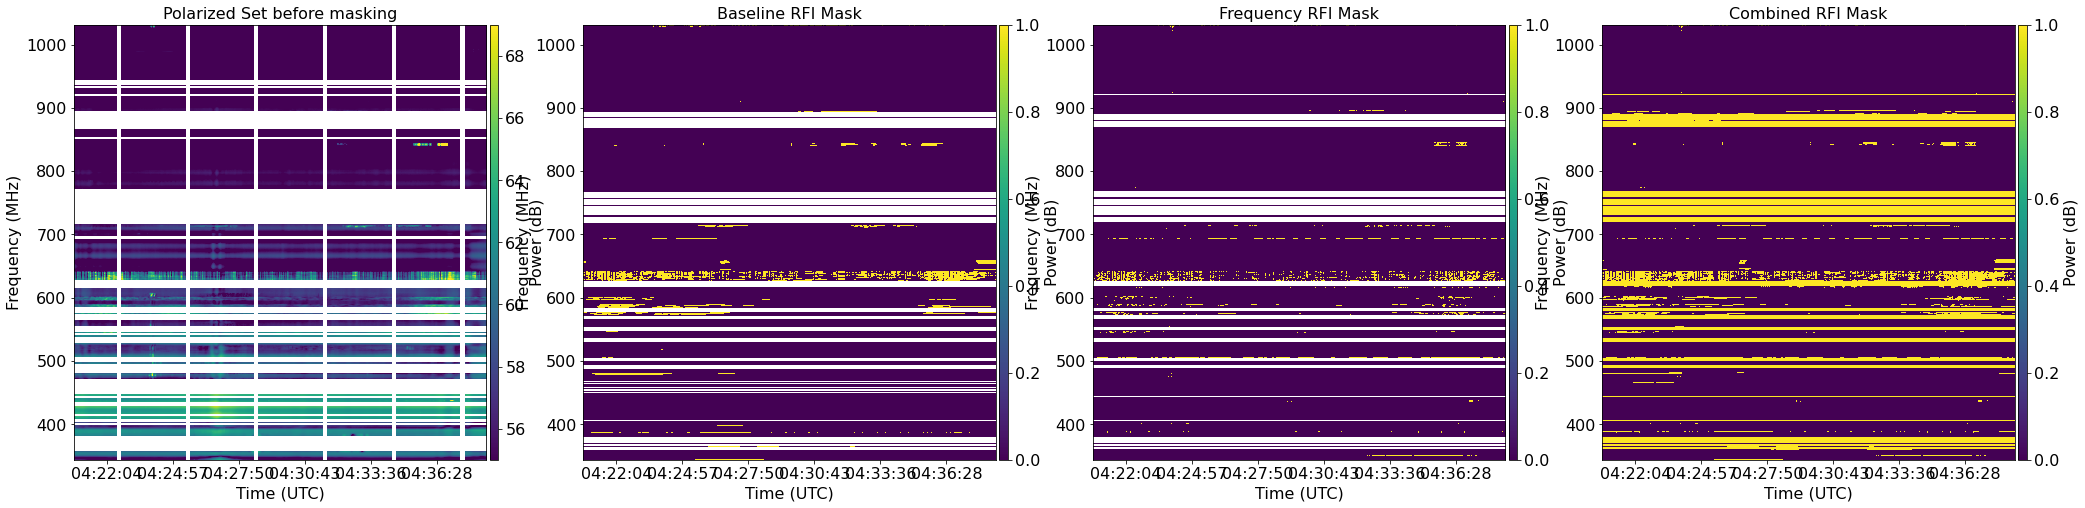

In [12]:
print("Total possible RFI Events:", total_possible)
print("Total confirmed RFI Events:", total_confirmed)

freq_start_idx = 0
freq_end_idx = -1
fig,axs = plt.subplots(1,4,figsize=(35,8))
fs = 16
#Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
polarized_power_min = 55
polarized_power_max = 69
im_pol = axs[0].imshow(10.*np.log10(polarized_set.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[0].set_xlim(t_plt[0],t_plt[-1])
axs[0].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[0].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[0].set_xlabel('Time (UTC)',fontsize=fs)        
axs[0].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[0].set_title('Polarized Set before masking', size = fs)

#full_scan_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
mask_power_min = 0
mask_power_max = 1
im_pol = axs[1].imshow(total_baseline_mask,aspect='auto',vmin=mask_power_min,vmax=mask_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]], interpolation = 'nearest')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[1].set_xlim(t_plt[0],t_plt[-1])
axs[1].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[1].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[1].set_xlabel('Time (UTC)',fontsize=fs)        
axs[1].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[1].set_title('Baseline RFI Mask', size = fs)

#confirmed_rfi_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
im_pol = axs[2].imshow(np.transpose(total_freq_mask),aspect='auto',vmin=mask_power_min,vmax=mask_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]], interpolation = 'nearest')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[2].set_xlim(t_plt[0],t_plt[-1])
axs[2].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs[2].tick_params(axis='both', labelsize=fs)
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[2].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[2].set_xlabel('Time (UTC)',fontsize=fs)        
axs[2].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[2].set_title('Frequency RFI Mask', size = fs)

#confirmed_rfi_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
im_pol = axs[3].imshow(np.transpose(combined_mask),aspect='auto',vmin=mask_power_min,vmax=mask_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]], interpolation = 'nearest')
divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[3].set_xlim(t_plt[0],t_plt[-1])
axs[3].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs[3].tick_params(axis='both', labelsize=fs)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[3].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[3].set_xlabel('Time (UTC)',fontsize=fs)        
axs[3].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[3].set_title('Combined RFI Mask', size = fs)

# # #Polarized_Masked Waterfall ---------------------------------------------------------------------------------------------------------------------------
# im_pol = axs[2].imshow(10.*np.log10(polarized_set_masked.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
#         extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
# divider = make_axes_locatable(axs[2])
# cax = divider.append_axes('right', size='2%', pad=0.05)
# cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
# cbar.ax.tick_params(labelsize=fs) 
# cbar.set_label('Power (dB)', fontsize=fs)
# axs[2].set_xlim(t_plt[0],t_plt[-1])
# axs[2].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
# axs[2].tick_params(axis='both', labelsize=fs)
# axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# axs[2].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
# axs[2].set_xlabel('Time (UTC)',fontsize=fs)        
# axs[2].set_ylabel('Frequency (MHz)',fontsize=fs)
# axs[2].set_title('Polarized Set after masking', size = fs)

#Arbitraty constants for visualization   

# Polarized Set Before Masking

Text(0.5, 1.0, 'Polarized Set before masking')

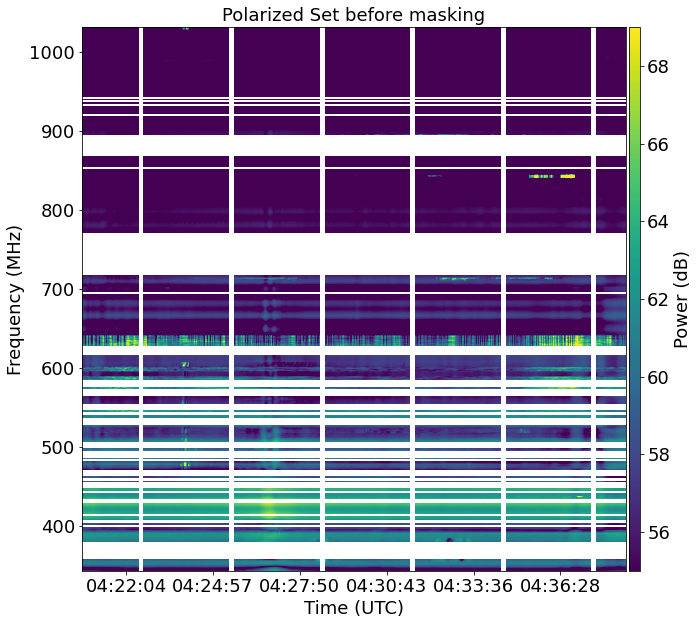

In [13]:
freq_start_idx = 0
freq_end_idx = -1
fig,axs = plt.subplots(1,1,figsize=(10,10))
fs = 18
#Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
polarized_power_min = 55
polarized_power_max = 69
im_pol = axs.imshow(10.*np.log10(polarized_set.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs.set_xlim(t_plt[0],t_plt[-1])
axs.set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs.tick_params(axis='both', labelsize=fs)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)
axs.set_title('Polarized Set before masking', size = fs)

In [14]:
print(freq[0])
print(freq[-1])

343.77083333333337
1031.1875


# Baseline RFI Mask

(1803, 8231)


Text(0.5, 1.0, 'Time-Domain RFI Mask')

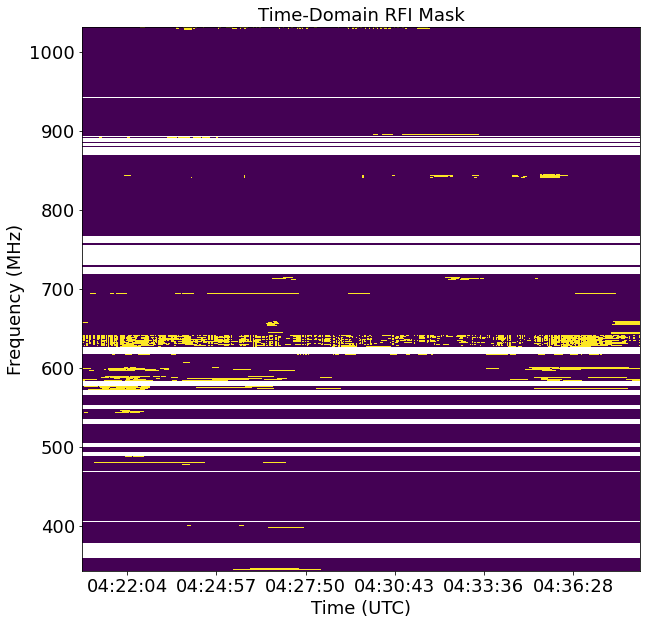

In [15]:
freq_start_idx = 0
freq_end_idx = -1
fig,axs = plt.subplots(1,1,figsize=(10,10))
fs = 18
print(np.shape(combined_mask))
# combined_mask[:,RFI_mask_idx] = 0

#full_scan_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
mask_power_min = 0
mask_power_max = 1
im_pol = axs.imshow(total_baseline_mask,aspect='auto',origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]], vmin = mask_power_min, vmax = mask_power_max, interpolation = 'nearest')
divider = make_axes_locatable(axs)

axs.set_xlim(t_plt[0],t_plt[-1])
axs.set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs.tick_params(axis='both', labelsize=fs)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)
axs.set_title('Time-Domain RFI Mask', size = fs)

# Step-By-Step Mask Analysis
### Work that will be used for the presentation:

In [16]:
# reload(rfi)
# def DVA_Apply_RFI_Excision(polarized_set, LL_set, freq_threshold, base_mult): #TODO: remove the LL_Set

#     polarized_set_masked = polarized_set.copy()
#     total_possible = 0
#     total_confirmed = 0
#     total_baseline_mask = []
#     total_OG_mask = []
#     confirmed_rfi_mask = []
#     LL_set_masked = LL_set.copy()
#     for freq_idx in range(0, len(freq)-2): #test up to 20 for now
#         OG_mask = np.zeros(len(LL_set[:, freq_idx]))
#         confirmed_RFI_results, number_of_possible, number_of_confirmed = rfi.RFI_Detection(freq_slope_threshold=freq_threshold, freq_idx = freq_idx, baseline_multiplier=base_mult, polarized_set = polarized_set, df = (freq[1] - freq[0]), apply_freq_verification = True)
#         confirmed_rfi_idxes = rfi.GenerateRfiIndexes(confirmed_RFI_results, t_plt)[0]
#         OG_mask[confirmed_rfi_idxes] = 1
#         total_OG_mask.append(OG_mask)
#         polarized_set_masked[confirmed_rfi_idxes, freq_idx] = np.nan
#         LL_set_masked[confirmed_rfi_idxes, freq_idx] = np.nan

#         confirmed_freq_mask = np.zeros(len(LL_set[:, freq_idx]))
#         confirmed_freq_mask[confirmed_rfi_idxes] = 1
#         confirmed_rfi_mask.append(confirmed_freq_mask)

#         baseline_mask = np.zeros(len(LL_set[:, freq_idx]))
#         baseline_RFI_results, number_of_confirmed = rfi2.RFI_Detection(freq_slope_threshold=freq_threshold, freq_idx = freq_idx, baseline_multiplier=base_mult, polarized_set = polarized_set, df = (freq[1] - freq[0]))
#         baseline_RFI_idx = rfi.GenerateRfiIndexes(baseline_RFI_results, t_plt)[0]
#         baseline_mask[baseline_RFI_idx] = 1
#         total_baseline_mask.append(baseline_mask)

#         total_possible += number_of_possible
#         total_confirmed += number_of_confirmed

#     total_freq_mask = []
#     for time_idx in range(0, len(polarized_set[:, 0])): #Changee this to polarized set
#         data_plot_L = 10*np.log10(polarized_set[time_idx,:])

#         window_size = 20
#         LL_smoothed = moving_average(data_plot_L, window_size)
#         freq_reduced= freq[:-(window_size-1)]
#         LL_reduced = data_plot_L[:-(window_size-1)]
#         LL_diff = np.abs(LL_smoothed - LL_reduced)
#         freq_mask = np.zeros(len(LL_diff))
#         freq_mask_idxes = np.where(LL_diff > 0.5) #TODO: Make this 0.5 an explicit arbitrary variable
#         freq_mask[freq_mask_idxes] = 1
#         total_freq_mask.append(freq_mask)

    
#     # return polarized_set_masked, LL_set_masked, possible_rfi_mask, confirmed_rfi_mask, total_confirmed, total_possible
#     return polarized_set_masked, LL_set_masked, total_baseline_mask, total_freq_mask, total_confirmed, total_possible, total_OG_mask

# polarized_set_masked, LL_set_masked, total_baseline_mask, total_freq_mask, total_confirmed, total_possible, total_OG_mask = DVA_Apply_RFI_Excision(polarized_set, LL_set, freq_threshold = 1e6, base_mult = 3)

# ###############################################################################################################
# freq_diff = np.abs(len(total_freq_mask[0]) - len(total_baseline_mask))
# total_baseline_mask_trimmed = np.transpose(total_baseline_mask[:-freq_diff]) #I need to cutout idxs that go beyond the trimmed version
# combined_mask = np.logical_or(total_baseline_mask_trimmed, total_freq_mask)


# window_size = 20
# total_baseline_mask = np.array(total_baseline_mask)
# RFI_mask_idx_trimmed = RFI_mask_idx[:-(window_size-1)]
# total_baseline_mask[RFI_mask_idx_trimmed,:] = np.nan

# print(np.shape(total_freq_mask))
# total_freq_mask = np.array(total_freq_mask)
# print(np.shape(total_freq_mask))
# total_freq_mask[:,RFI_mask_idx_trimmed] = np.nan

# combined_mask = np.array(combined_mask)
# print(np.shape(combined_mask))
# combined_mask[:,RFI_mask_idx_trimmed] = np.nan


# ###############################################################################################################
# #                                                   PLOTTING
# ###############################################################################################################
# print("Total possible RFI Events:", total_possible)
# print("Total confirmed RFI Events:", total_confirmed)

# freq_start_idx = 0
# freq_end_idx = -1
# fig,axs = plt.subplots(1,4,figsize=(35,8))
# fs = 16
# #Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
# polarized_power_min = 55
# polarized_power_max = 69
# im_pol = axs[0].imshow(10.*np.log10(polarized_set.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
#         extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
# divider = make_axes_locatable(axs[0])
# cax = divider.append_axes('right', size='2%', pad=0.05)
# cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
# cbar.ax.tick_params(labelsize=fs) 
# cbar.set_label('Power (dB)', fontsize=fs)
# axs[0].set_xlim(t_plt[0],t_plt[-1])
# axs[0].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
# axs[0].tick_params(axis='both', labelsize=fs)
# axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# axs[0].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
# axs[0].set_xlabel('Time (UTC)',fontsize=fs)        
# axs[0].set_ylabel('Frequency (MHz)',fontsize=fs)
# axs[0].set_title('Polarized Set before masking', size = fs)

# #full_scan_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
# mask_power_min = 0
# mask_power_max = 1
# im_pol = axs[1].imshow(total_baseline_mask,aspect='auto',vmin=mask_power_min,vmax=mask_power_max,origin='lower',
#         extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
# divider = make_axes_locatable(axs[1])
# cax = divider.append_axes('right', size='2%', pad=0.05)
# cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
# cbar.ax.tick_params(labelsize=fs) 
# cbar.set_label('Power (dB)', fontsize=fs)
# axs[1].set_xlim(t_plt[0],t_plt[-1])
# axs[1].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
# axs[1].tick_params(axis='both', labelsize=fs)
# axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# axs[1].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
# axs[1].set_xlabel('Time (UTC)',fontsize=fs)        
# axs[1].set_ylabel('Frequency (MHz)',fontsize=fs)
# axs[1].set_title('Baseline RFI Mask', size = fs)

# #confirmed_rfi_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
# im_pol = axs[2].imshow(np.transpose(total_freq_mask),aspect='auto',vmin=mask_power_min,vmax=mask_power_max,origin='lower',
#         extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
# divider = make_axes_locatable(axs[2])
# cax = divider.append_axes('right', size='2%', pad=0.05)
# cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
# cbar.ax.tick_params(labelsize=fs) 
# cbar.set_label('Power (dB)', fontsize=fs)
# axs[2].set_xlim(t_plt[0],t_plt[-1])
# axs[2].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
# axs[2].tick_params(axis='both', labelsize=fs)
# axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# axs[2].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
# axs[2].set_xlabel('Time (UTC)',fontsize=fs)        
# axs[2].set_ylabel('Frequency (MHz)',fontsize=fs)
# axs[2].set_title('Frequency RFI Mask', size = fs)

# #confirmed_rfi_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
# im_pol = axs[3].imshow(np.transpose(combined_mask),aspect='auto',vmin=mask_power_min,vmax=mask_power_max,origin='lower',
#         extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
# divider = make_axes_locatable(axs[3])
# cax = divider.append_axes('right', size='2%', pad=0.05)
# cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
# cbar.ax.tick_params(labelsize=fs) 
# cbar.set_label('Power (dB)', fontsize=fs)
# axs[3].set_xlim(t_plt[0],t_plt[-1])
# axs[3].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
# axs[3].tick_params(axis='both', labelsize=fs)
# axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# axs[3].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
# axs[3].set_xlabel('Time (UTC)',fontsize=fs)        
# axs[3].set_ylabel('Frequency (MHz)',fontsize=fs)
# axs[3].set_title('Combined RFI Mask', size = fs)

# # # #Polarized_Masked Waterfall ---------------------------------------------------------------------------------------------------------------------------
# # im_pol = axs[2].imshow(10.*np.log10(polarized_set_masked.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
# #         extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
# # divider = make_axes_locatable(axs[2])
# # cax = divider.append_axes('right', size='2%', pad=0.05)
# # cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
# # cbar.ax.tick_params(labelsize=fs) 
# # cbar.set_label('Power (dB)', fontsize=fs)
# # axs[2].set_xlim(t_plt[0],t_plt[-1])
# # axs[2].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
# # axs[2].tick_params(axis='both', labelsize=fs)
# # axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# # axs[2].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
# # axs[2].set_xlabel('Time (UTC)',fontsize=fs)        
# # axs[2].set_ylabel('Frequency (MHz)',fontsize=fs)
# # axs[2].set_title('Polarized Set after masking', size = fs)

# #Arbitraty constants for visualization   

# Applying the combined RFI Mask

Text(0.5, 1.0, 'Polarized Set with Combined Mask')

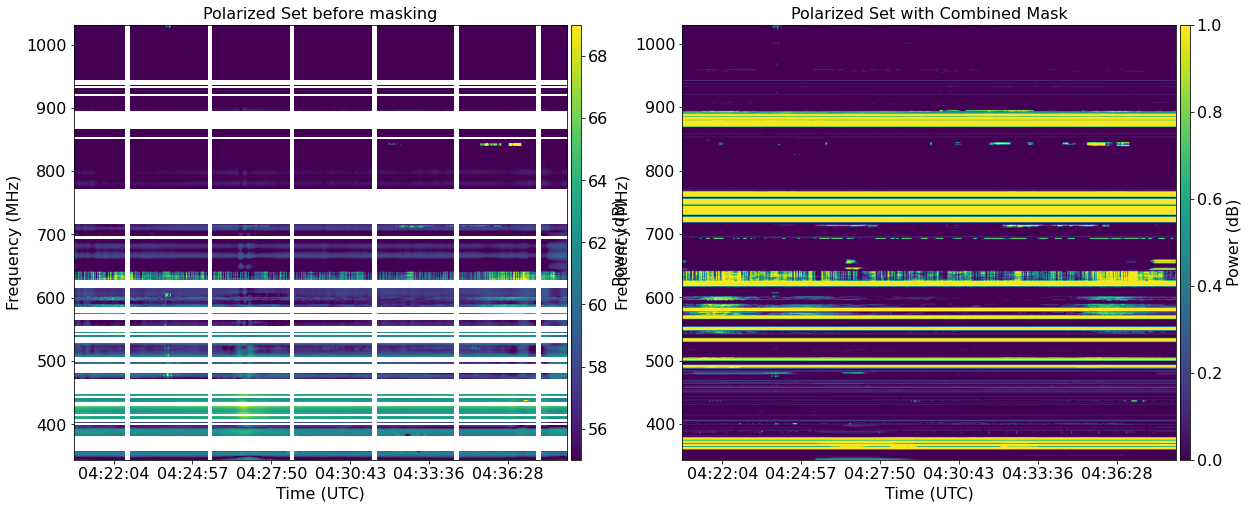

In [17]:
#Apply Becky's Mask
#Apply Combined RFI mask
polarized_set_masked = polarized_set.copy()
polarized_set_masked[:,RFI_mask_idx_trimmed] = np.nan

LL_set_masked = LL_set.copy()

window_size = 20
freq_reduced = freq[:-(window_size-1)]

for freq_idx in range(0, len(freq_reduced)-1): #test up to 20 for now
        time_combined_mask = combined_mask[:, freq_idx]
        polarized_set_masked[time_combined_mask, freq_idx] = np.nan
        LL_set_masked[time_combined_mask, freq_idx] = np.nan


freq_start_idx = 0
freq_end_idx = -1
fig,axs = plt.subplots(1,2,figsize=(20,8))
fs = 16

#Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
polarized_power_min = 55
polarized_power_max = 69
im_pol = axs[0].imshow(10.*np.log10(polarized_set.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[0].set_xlim(t_plt[0],t_plt[-1])
axs[0].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[0].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[0].set_xlabel('Time (UTC)',fontsize=fs)        
axs[0].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[0].set_title('Polarized Set before masking', size = fs)
#Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
polarized_power_min = 0#55
polarized_power_max = 1#69
# 10.*np.log10(polarized_set_masked.T)
im_pol = axs[1].imshow(combined_mask.T,aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq_reduced[0],freq_reduced[-1]])
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[1].set_xlim(t_plt[0],t_plt[-1])
axs[1].set_ylim(freq_reduced[freq_start_idx], freq_reduced[freq_end_idx])
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[1].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[1].set_xlabel('Time (UTC)',fontsize=fs)        
axs[1].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[1].set_title('Polarized Set with Combined Mask', size = fs)

Text(0.5, 1.0, 'LL_set for scan 1052')

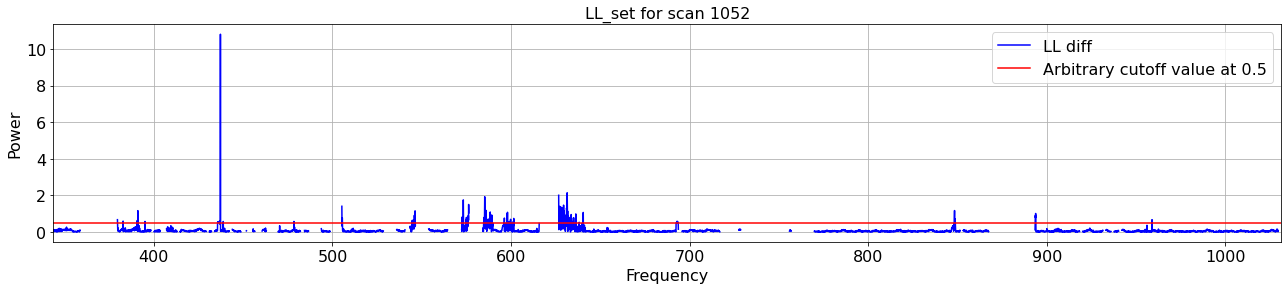

In [18]:
fig,axs1 = plt.subplots(1,1,figsize=(22,4))  

time_idx = 100
power_min = 65
power_max = 79
    
data_plot_L = 10*np.log10(LL_set[time_idx,:])
# data_plot_L = 10*np.log10(polarized_set[time_idx,:])
# data_plot_L = (polarized_set[time_idx,:])/1e8
data_plot_R = 10*np.log10(RR_set[time_idx,:])

window_size = 20
LL_smoothed = moving_average(data_plot_L, window_size)
freq_smoothed = freq[:-(window_size-1)]
reduced_LL = data_plot_L[:-(window_size-1)]
LL_diff = np.abs(LL_smoothed - reduced_LL)
LL_fixed = data_plot_L[:-(window_size-1)] - LL_diff
# axs1.plot(freq,data_plot_L,label='LL',color='red')   
# axs1.plot(freq_smoothed,LL_smoothed,label='Moving average',color='blue')
axs1.plot(freq_smoothed,LL_diff,label='LL diff',color='blue')
axs1.axhline(y = 0.5, label = "Arbitrary cutoff value at 0.5", color = "red")

# axs1.plot(freq_smoothed,LL_fixed,label='LL fixed',color='green')


# axs1.set_ylim(power_min,power_max) 
# axs1.set_ylim(0,0.5) 
axs1.set_xlim(freq[0],freq[-1])
axs1.set_xlabel('Frequency',fontsize=fs)
axs1.tick_params(axis='both',labelsize=fs)
axs1.set_ylabel('Power',fontsize=fs)
axs1.legend(fontsize=fs,markerscale=5)
axs1.grid()
plot_title = "LL_set for scan {}".format(scan_id[0])
# plot_title = "LL and moving average difference for scan {}".format(scan_id[0])
axs1.set_title(plot_title, fontsize = fs)
# plt.savefig(plot_title)
# print(scan_id[0])

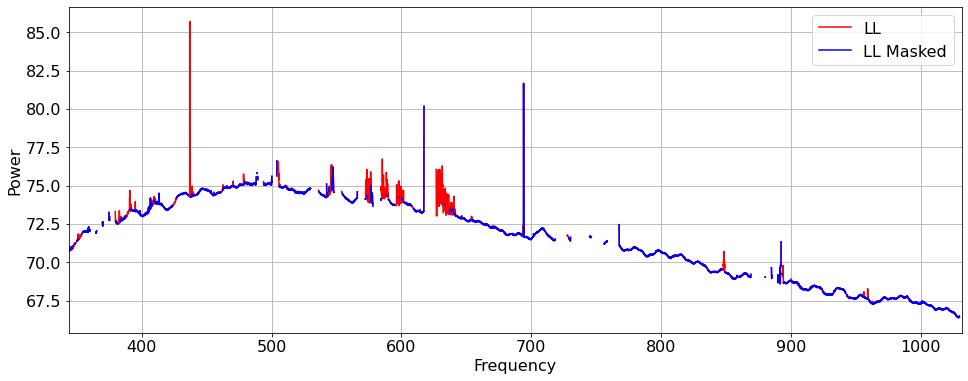

In [19]:
freq_mask = np.where(LL_diff > 0.1)
fig,axs1 = plt.subplots(1,1,figsize=(16,6))  
axs1.plot(freq_smoothed,reduced_LL,label='LL',color='red')

LL_masked = np.copy(reduced_LL)
LL_masked[freq_mask] = np.nan

axs1.plot(freq_smoothed,LL_masked,label='LL Masked',color='blue')
axs1.set_xlim(freq[0],freq[-1])
axs1.set_xlabel('Frequency',fontsize=fs)
axs1.tick_params(axis='both',labelsize=fs)
axs1.set_ylabel('Power',fontsize=fs)
axs1.legend(fontsize=fs,markerscale=5)
# axs1.set_ylim(0,0.5) 

axs1.grid()


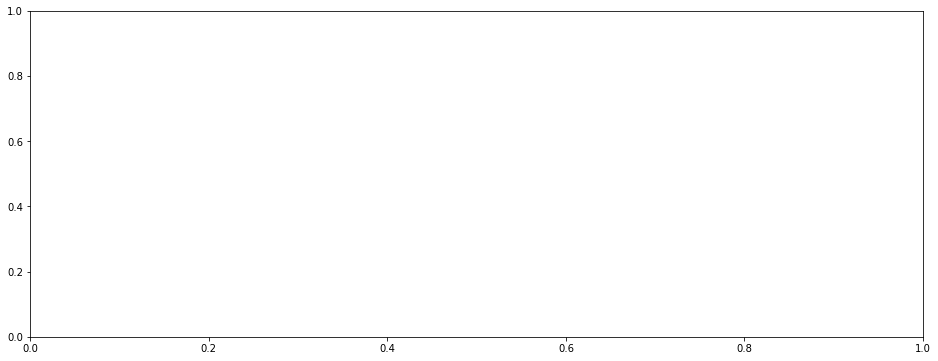

In [20]:
fig,axs1 = plt.subplots(1,1,figsize=(16,6))  

time_idx = 100
power_min = 65
power_max = 79
    
data_plot_L = 10*np.log10(LL_set[time_idx,:])
data_plot_R = 10*np.log10(RR_set[time_idx,:])

window_size = 3
LL_smoothed = moving_average(data_plot_L, window_size)
freq_smoothed = freq[:-(window_size-1)]
reduced_LL = data_plot_L[:-(window_size-1)]
LL_diff = np.abs(LL_smoothed - reduced_LL)
LL_fixed = data_plot_L[:-(window_size-1)] - LL_diff


reload(rfi)
def DVA_Plot_RFI(polarized_set, LL_set):
    freq_threshold = 1e6
    base_mult = 3

    polarized_set_masked = polarized_set.copy()
    total_possible = 0
    total_confirmed = 0
    possible_rfi_mask = []
    confirmed_rfi_mask = []
    LL_set_masked = LL_set.copy()
    total_freq_mask = []
    
    for time_idx in range(0, len(LL_set[:, 0])):
        data_plot_L = 10*np.log10(LL_set[time_idx,:])
        window_size = 3
        LL_smoothed = moving_average(data_plot_L, window_size)
        freq_reduced= freq[:-(window_size-1)]
        LL_reduced = data_plot_L[:-(window_size-1)]
        LL_diff = np.abs(LL_smoothed - LL_reduced)
        freq_mask = np.where(LL_diff > 0.1)
        total_freq_mask.append(freq_mask)

    return polarized_set_masked, LL_set_masked, possible_rfi_mask, total_freq_mask, total_confirmed, total_possible

polarized_set_masked, LL_set_masked, possible_rfi_mask, confirmed_rfi_mask, total_confirmed, total_possible = DVA_Plot_RFI(polarized_set, LL_set)


In [21]:
reload(rfi)
def DVA_Plot_RFI(polarized_set, LL_set):
    freq_threshold = 1e6
    base_mult = 3

    polarized_set_masked = polarized_set.copy()
    total_possible = 0
    total_confirmed = 0
    possible_rfi_mask = []
    confirmed_rfi_mask = []
    LL_set_masked = LL_set.copy()
    for freq_idx in range(0, len(freq)-2): #test up to 20 for now
        confirmed_RFI_results, number_of_possible, number_of_confirmed = rfi.RFI_Detection(freq_slope_threshold=freq_threshold, freq_idx = freq_idx, baseline_multiplier=base_mult, polarized_set = polarized_set, df = (freq[1] - freq[0]), apply_freq_verification = True)
        confirmed_rfi_idxes = rfi.GenerateRfiIndexes(confirmed_RFI_results, t_plt)[0]
        polarized_set_masked[confirmed_rfi_idxes, freq_idx] = np.nan
        LL_set_masked[confirmed_rfi_idxes, freq_idx] = np.nan

        confirmed_freq_mask = np.zeros(len(LL_set[:, freq_idx]))
        confirmed_freq_mask[confirmed_rfi_idxes] = 1
        confirmed_rfi_mask.append(confirmed_freq_mask)

        possible_freq_mask = np.zeros(len(LL_set[:, freq_idx]))
        confirmed_RFI_results, number_of_confirmed = rfi2.RFI_Detection(freq_slope_threshold=freq_threshold, freq_idx = freq_idx, baseline_multiplier=base_mult, polarized_set = polarized_set, df = (freq[1] - freq[0]))
        confirmed_rfi_idxes = rfi.GenerateRfiIndexes(confirmed_RFI_results, t_plt)[0]
        possible_freq_mask[confirmed_rfi_idxes] = 1
        possible_rfi_mask.append(possible_freq_mask)

        total_possible += number_of_possible
        total_confirmed += number_of_confirmed

    total_freq_mask = []
    for time_idx in range(0, len(LL_set[:, 0])):
        data_plot_L = 10*np.log10(LL_set[time_idx,:])
        window_size = 3
        LL_smoothed = moving_average(data_plot_L, window_size)
        freq_reduced= freq[:-(window_size-1)]
        LL_reduced = data_plot_L[:-(window_size-1)]
        LL_diff = np.abs(LL_smoothed - LL_reduced)
        freq_mask = np.where(LL_diff > 0.1)
        total_freq_mask.append(freq_mask)

    
    # return polarized_set_masked, LL_set_masked, possible_rfi_mask, confirmed_rfi_mask, total_confirmed, total_possible
    return polarized_set_masked, LL_set_masked, possible_rfi_mask, total_freq_mask, total_confirmed, total_possible

polarized_set_masked, LL_set_masked, possible_rfi_mask, total_freq_mask, total_confirmed, total_possible = DVA_Plot_RFI(polarized_set, LL_set)

c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Total possible RFI Events: 30882
Total confirmed RFI Events: 29628


c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:682: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

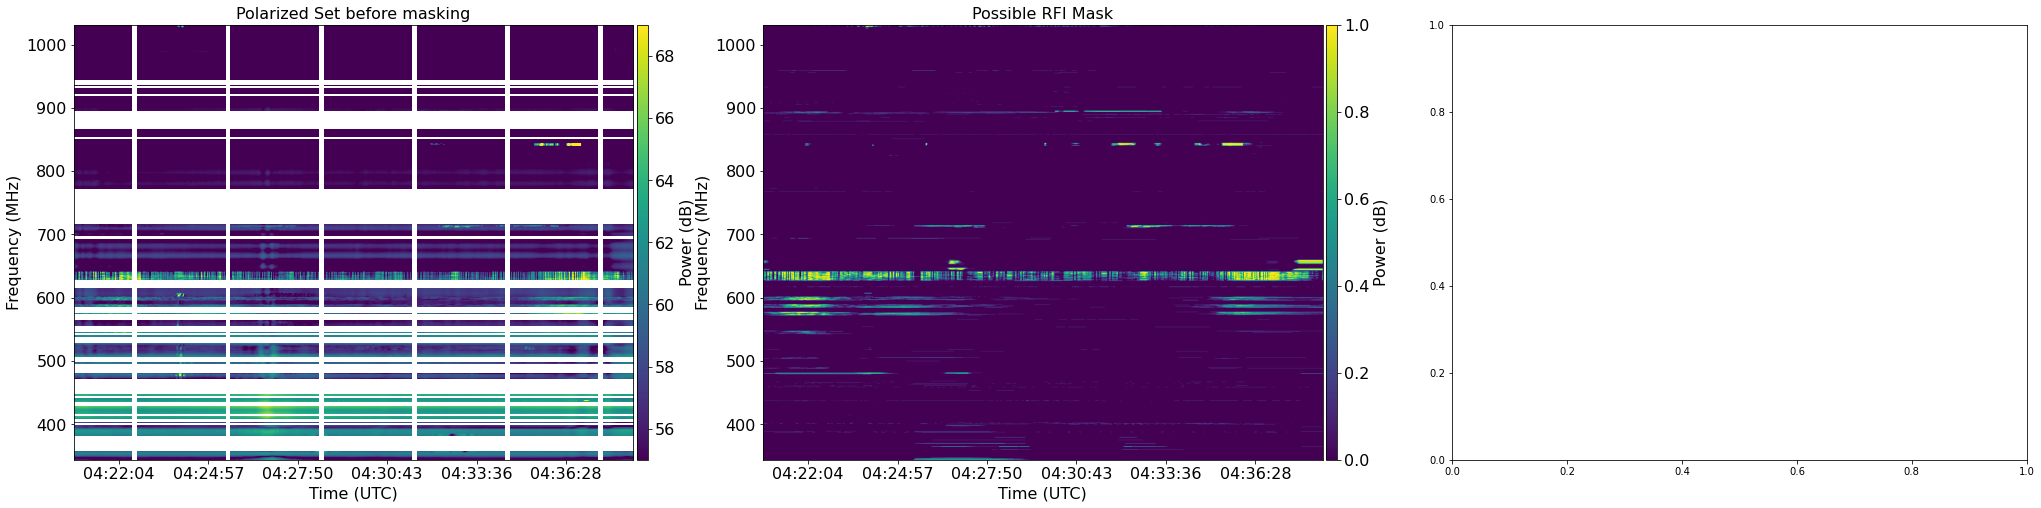

In [22]:
print("Total possible RFI Events:", total_possible)
print("Total confirmed RFI Events:", total_confirmed)

freq_start_idx = 0
freq_end_idx = -1
fig,axs = plt.subplots(1,3,figsize=(35,8))
fs = 16
#Polarized Waterfall ---------------------------------------------------------------------------------------------------------------------------
polarized_power_min = 55
polarized_power_max = 69
im_pol = axs[0].imshow(10.*np.log10(polarized_set.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[0].set_xlim(t_plt[0],t_plt[-1])
axs[0].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[0].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[0].set_xlabel('Time (UTC)',fontsize=fs)        
axs[0].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[0].set_title('Polarized Set before masking', size = fs)

#full_scan_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
mask_power_min = 0
mask_power_max = 1
im_pol = axs[1].imshow(possible_rfi_mask,aspect='auto',vmin=mask_power_min,vmax=mask_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[1].set_xlim(t_plt[0],t_plt[-1])
axs[1].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[1].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[1].set_xlabel('Time (UTC)',fontsize=fs)        
axs[1].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[1].set_title('Possible RFI Mask', size = fs)

#confirmed_rfi_mask Waterfall ---------------------------------------------------------------------------------------------------------------------------
im_pol = axs[2].imshow(confirmed_rfi_mask,aspect='auto',vmin=mask_power_min,vmax=mask_power_max,origin='lower',
        extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)
axs[2].set_xlim(t_plt[0],t_plt[-1])
axs[2].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
axs[2].tick_params(axis='both', labelsize=fs)
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs[2].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs[2].set_xlabel('Time (UTC)',fontsize=fs)        
axs[2].set_ylabel('Frequency (MHz)',fontsize=fs)
axs[2].set_title('Confirmed RFI Mask', size = fs)

# #Polarized_Masked Waterfall ---------------------------------------------------------------------------------------------------------------------------
# im_pol = axs[2].imshow(10.*np.log10(polarized_set_masked.T),aspect='auto',vmin=polarized_power_min,vmax=polarized_power_max,origin='lower',
#         extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])
# divider = make_axes_locatable(axs[2])
# cax = divider.append_axes('right', size='2%', pad=0.05)
# cbar = fig.colorbar(im_pol, cax=cax, orientation='vertical')
# cbar.ax.tick_params(labelsize=fs) 
# cbar.set_label('Power (dB)', fontsize=fs)
# axs[2].set_xlim(t_plt[0],t_plt[-1])
# axs[2].set_ylim(freq[freq_start_idx], freq[freq_end_idx])
# axs[2].tick_params(axis='both', labelsize=fs)
# axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# axs[2].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
# axs[2].set_xlabel('Time (UTC)',fontsize=fs)        
# axs[2].set_ylabel('Frequency (MHz)',fontsize=fs)
# axs[2].set_title('Polarized Set after masking', size = fs)


        

#Arbitraty constants for visualization   

# Idea:

When I'm finding a possible RFI:
- Find the first time I'm crossing the baseline to the left -> Mark that as the start
- Find the first time I'm crossing the baseline to the right -> Mark that as the end

# Ideas

Maybe I could try implementing the "variance" compression method:
- check the variance of 5 points. if below threshold, compress 5 values with the same baseline value.
- Note: 5 is an arbitrary choice. I could even have a larger variance interval, and if the variance is high, I start dividing my large interval into smaller chunks looking for the high variance intervals